# Practical Assignment 6

In this assignment a GAN is trained on the MNIST dataset. The MNIST dataset (provided by Yann Lecun) consists of handwritten digits of which an example is shown in figure 1. 

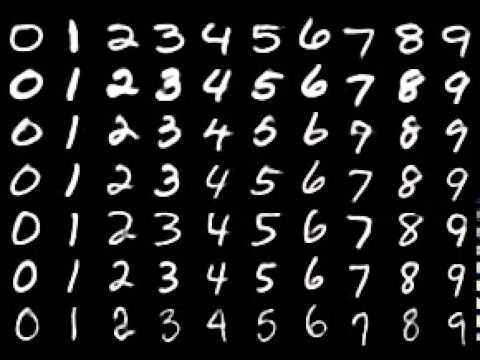

Figure 1: An example of the MNIST dataset

#### Imports

In [9]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from utils import RandomIterator, get_mnist # as provided in the course
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

####  Defining the network
In the class below the structure of the generator (GAN) is defined and a classifier wrapper is defined


In [78]:
class Generator(Chain):
    def __init__(self):
        super(Generator, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 28*28)
            self.b1 = L.BatchNormalization(28 * 28 * 255)
            self.d1 = L.Deconvolution2D(None, None, outsize=(28, 28))
            
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.self.b1(h)
        output = F.sigmoid(self.d1(h))
        return output
    
    def gen(self): 
        return np.random.random_sample((28, 28))
    
class Classifier(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    for accuracy evaluation and prediction
    
    """
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x):
       
        y = self.predictor(x)
        #loss = F.softmax_cross_entropy(y, t)
        #accuracy = F.accuracy(y, t)
        #report({'loss': loss, 'accuracy': accuracy}, self)
        return y

In the class below the structure of the discriminator (GAN) is defined and a classifier wrapper is defined. 

In [79]:
class Discriminator(Chain):
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 1)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        output = F.sigmoid(self.l1(h))
        return output
    
class Classifier(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    for accuracy evaluation and prediction
    
    """
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x):
        x = F.expand_dims(x,0)
        x = F.expand_dims(x,1)
        y = self.predictor(x)
        #loss = F.softmax_cross_entropy(y, t)
        #accuracy = F.accuracy(y, t)
        #report({'loss': loss, 'accuracy': accuracy}, self)
        return y

#### Training set creation

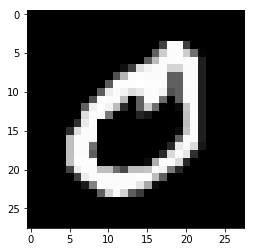

In [80]:
# Retrieve train & test data      
train_data, test_data = get_mnist(n_train=1000, n_test=100, with_label=False, classes=[0])
plt.imshow((train_data[1][0]), cmap='gray')

#### Implement the training & test loop


In [81]:
dis = Discriminator()
classifier_dis = Classifier(dis)
optimizer_dis = optimizers.Adam()
optimizer_dis.setup(classifier_dis)

gen = Generator()
classifier_gen = Classifier(gen)
optimizer_gen = optimizers.Adam()
optimizer_gen.setup(classifier_gen)

In [90]:
epochs = 20
ri = RandomIterator(train_data, 1)
gen_loss = []
dis_loss = []
for i in range(epochs):
    for batch in ri:
        x = batch[0][0].astype('float32')
        z = gen.gen().astype('float32')
        
        # Update Discriminator
        classifier_dis.cleargrads()
        y_fake = F.sum(classifier_dis(z)) 
        y_real = F.sum(classifier_dis(x))
        loss_d = -F.log(y_real) - F.log(1 - y_fake) 
        dis_loss.append({'epoch': i, 'loss': loss_d.data})
        loss_d.backward()
        optimizer_dis.update()
        
        # Update Generator
        gen.cleargrads()
        loss_g = -F.log(y_fake)
        gen_loss.append({'epoch': i, 'loss': loss_g.data})
        loss_g.backward()
        optimizer_gen.update()
   
     

/home/abdullahi/anaconda3/envs/py27/lib/python2.7/site-packages/chainer/functions/math/exponential.py:49: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),
/home/abdullahi/anaconda3/envs/py27/lib/python2.7/site-packages/chainer/functions/math/exponential.py:55: RuntimeWarning: divide by zero encountered in divide
  return utils.force_array(gy[0] / x[0]),
/home/abdullahi/anaconda3/envs/py27/lib/python2.7/site-packages/chainer/functions/activation/sigmoid.py:47: RuntimeWarning: invalid value encountered in multiply
  return utils.force_array(gy[0] * y * (one - y)),


#### Plotting training and test loss versus epoch

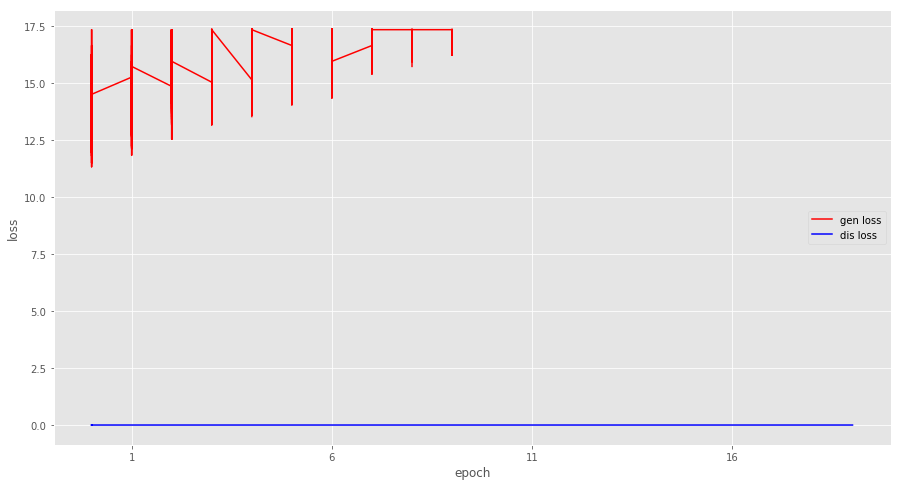

In [93]:
def visualize_loss(gen_loss, dis_loss, nr_epochs=50):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    xticks = np.arange(1, nr_epochs+1, 5)
    ax.set_xticks(xticks)  
    e_gen, l_gen = [point['epoch'] for point in gen_loss], [point['loss'] for point in gen_loss]
    e_dis, l_dis = [point['epoch'] for point in dis_loss], [point['loss'] for point in dis_loss]
    gen, = plt.plot(e_gen, l_gen, 'r', label = 'gen loss')
    dis, = plt.plot(e_dis, l_dis, 'b', label = 'dis loss')
    plt.legend([gen, dis], ['gen loss', 'dis loss'])
    plt.show() 
visualize_loss(gen_loss, dis_loss, nr_epochs=20)

### Generate 10 samples

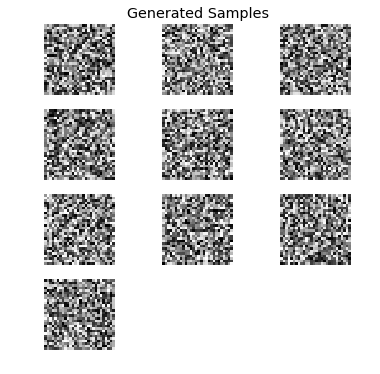

In [97]:
fig = plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('Generated Samples')
for i in range(10):
    z = gen.gen().astype('float32')
    sub = fig.add_subplot(4,3,i+1)
    sub.imshow(z, cmap = 'gray')
    plt.axis('off')